<a href="https://colab.research.google.com/github/Kartik-loop/Interactive_Sales_Dashboard/blob/main/dashboard_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
from google.colab import files
uploaded = files.upload()

Saving sales_data (2).csv to sales_data (2) (1).csv


✅ Data Loaded Successfully!
        Date     Product  Quantity  Price Customer_ID Region  Total_Sales  \
0 2024-01-01       Phone         7  37300     CUST001   East       261100   
1 2024-01-02  Headphones         4  15406     CUST002  North        61624   
2 2024-01-03       Phone         2  21746     CUST003   West        43492   
3 2024-01-04  Headphones         1  30895     CUST004   East        30895   
4 2024-01-05      Laptop         8  39835     CUST005  North       318680   

   Profit_Margin        Profit  
0       0.174908  45668.485006  
1       0.290143  17879.763684  
2       0.246399  10716.376103  
3       0.219732   6788.610774  
4       0.131204  41812.004067  


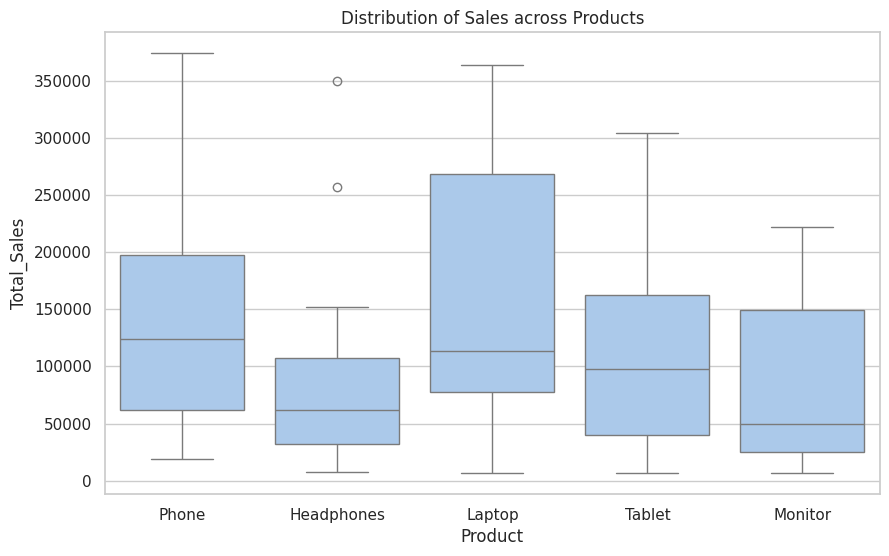

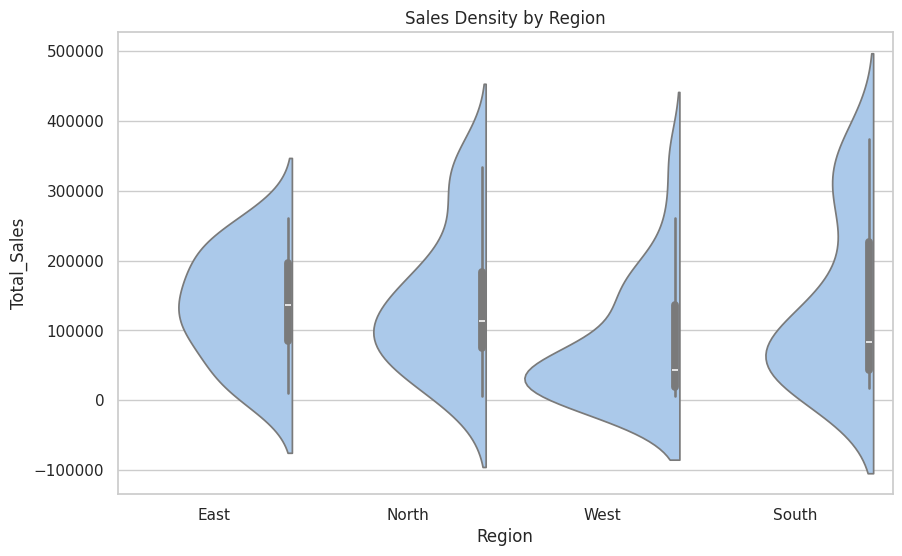

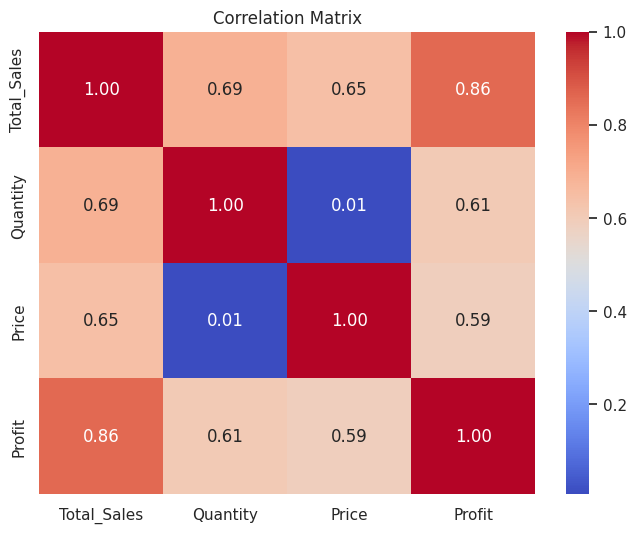

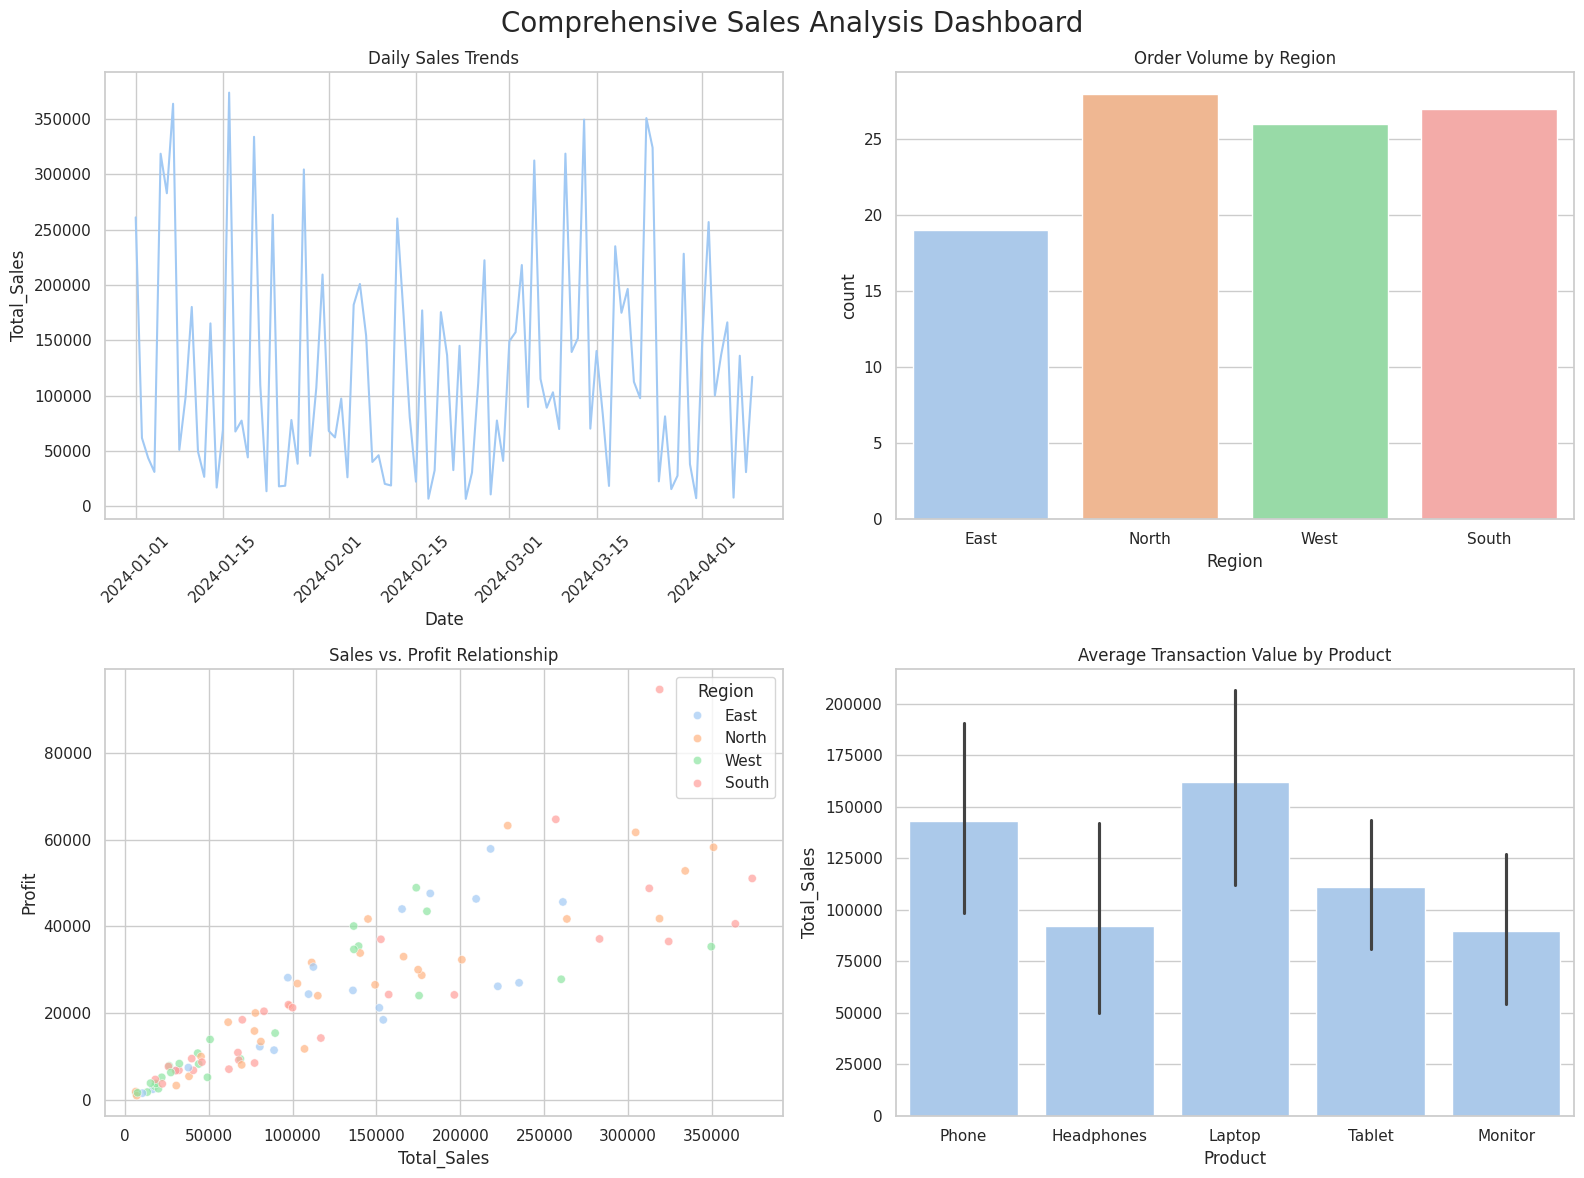

In [27]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

# 1. Setup the project folder structure inside Colab
if not os.path.exists('visualizations'):
    os.makedirs('visualizations')

# Set global aesthetics for professional look
sns.set_theme(style="whitegrid", palette="pastel")
plt.rcParams['figure.figsize'] = (12, 6)

# ------------------------------------------
# LOAD DATA
# ------------------------------------------
try:
    # Read the CSV you uploaded
    df = pd.read_csv('sales_data (2).csv')

    # Convert Date to datetime
    df['Date'] = pd.to_datetime(df['Date'])

    # SIMULATE PROFIT (Since your data doesn't have it)
    # We assume a profit margin between 10% and 30%
    np.random.seed(42)
    df['Profit_Margin'] = np.random.uniform(0.10, 0.30, size=len(df))
    df['Profit'] = df['Total_Sales'] * df['Profit_Margin']

    print("✅ Data Loaded Successfully!")
    print(df.head())

except FileNotFoundError:
    print("❌ Error: Please upload 'sales_data (2).csv' to the Colab files section on the left.")

# ------------------------------------------
# STATISTICAL VISUALIZATIONS
# ------------------------------------------

if 'df' in locals():
    # 1. Box Plot: Sales by Product
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Product', y='Total_Sales', data=df)
    plt.title('Distribution of Sales across Products')
    plt.savefig('visualizations/boxplot_sales.png') # Save for your GitHub
    plt.show()

    # 2. Violin Plot: Sales Density by Region
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='Region', y='Total_Sales', data=df, split=True)
    plt.title('Sales Density by Region')
    plt.savefig('visualizations/violin_sales.png')
    plt.show()

    # 3. Correlation Heatmap
    plt.figure(figsize=(8, 6))
    numerical_df = df[['Total_Sales', 'Quantity', 'Price', 'Profit']]
    corr_matrix = numerical_df.corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix')
    plt.savefig('visualizations/heatmap_corr.png')
    plt.show()

    # 4. The 2x2 Dashboard Grid
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Comprehensive Sales Analysis Dashboard', fontsize=20)

    # Top Left: Line Chart
    sns.lineplot(ax=axes[0, 0], x='Date', y='Total_Sales', data=df, estimator='sum', errorbar=None)
    axes[0, 0].set_title('Daily Sales Trends')
    axes[0, 0].tick_params(axis='x', rotation=45)

    # Top Right: Count Plot
    sns.countplot(ax=axes[0, 1], x='Region', data=df, hue='Region', legend=False)
    axes[0, 1].set_title('Order Volume by Region')

    # Bottom Left: Scatter Plot
    sns.scatterplot(ax=axes[1, 0], x='Total_Sales', y='Profit', hue='Region', data=df, alpha=0.7)
    axes[1, 0].set_title('Sales vs. Profit Relationship')

    # Bottom Right: Bar Chart
    sns.barplot(ax=axes[1, 1], x='Product', y='Total_Sales', data=df, estimator='mean')
    axes[1, 1].set_title('Average Transaction Value by Product')

    plt.tight_layout()
    plt.savefig('visualizations/subplots_dashboard.png')
    plt.show()

In [29]:
%%writefile dashboard.py
import streamlit as st
import pandas as pd
import numpy as np
import plotly.express as px

# --- 1. CONFIGURATION ---
st.set_page_config(page_title="Executive Sales Dashboard", layout="wide")
st.title("📊 Interactive Sales Performance Dashboard")

# --- 2. DATA LOADING ---
@st.cache_data
def load_data():
    try:
        # Load data
        df = pd.read_csv('sales_data (2).csv')
        df['Date'] = pd.to_datetime(df['Date'])

        # Simulate Profit (Same logic as notebook)
        np.random.seed(42)
        df['Profit_Margin'] = np.random.uniform(0.10, 0.30, size=len(df))
        df['Profit'] = df['Total_Sales'] * df['Profit_Margin']

        return df
    except Exception as e:
        st.error(f"Error loading data: {e}")
        return pd.DataFrame()

df = load_data()

# --- 3. SIDEBAR FILTERS ---
st.sidebar.header("Filter Options")

if not df.empty:
    # Product Filter
    selected_product = st.sidebar.multiselect(
        "Select Product:",
        options=df["Product"].unique(),
        default=df["Product"].unique()
    )

    # Region Filter
    selected_region = st.sidebar.multiselect(
        "Select Region:",
        options=df["Region"].unique(),
        default=df["Region"].unique()
    )

    # Filter Data
    filtered_df = df[
        (df["Product"].isin(selected_product)) &
        (df["Region"].isin(selected_region))
    ]

    # --- 4. KPI METRICS ---
    col1, col2, col3 = st.columns(3)
    col1.metric("Total Sales", f"${filtered_df['Total_Sales'].sum():,.2f}")
    col2.metric("Est. Profit", f"${filtered_df['Profit'].sum():,.2f}")
    col3.metric("Transactions", len(filtered_df))

    st.markdown("---")

    # --- 5. CHARTS (ROW 1) ---
    c1, c2 = st.columns([2, 1])

    with c1:
        st.subheader("Sales Trend")
        daily_sales = filtered_df.sort_values('Date')
        fig_line = px.line(daily_sales, x='Date', y='Total_Sales', markers=True)
        st.plotly_chart(fig_line, use_container_width=True)

    with c2:
        st.subheader("Region Share")
        fig_pie = px.pie(filtered_df, names='Region', values='Total_Sales', hole=0.4)
        st.plotly_chart(fig_pie, use_container_width=True)

    # --- 6. CHARTS (ROW 2) ---
    c3, c4 = st.columns(2)

    with c3:
        st.subheader("Profit Analysis")
        fig_scat = px.scatter(filtered_df, x="Total_Sales", y="Profit", color="Region", size="Quantity")
        st.plotly_chart(fig_scat, use_container_width=True)

    with c4:
        st.subheader("Product Performance")
        fig_box = px.box(filtered_df, x="Product", y="Total_Sales", color="Product")
        st.plotly_chart(fig_box, use_container_width=True)

Writing dashboard.py


In [ ]:
# 1. Install Streamlit
!pip install -q streamlit

# 2. Run Streamlit in the background and use LocalTunnel to expose it
import urllib
print("Password/Endpoint IP for localtunnel is:", urllib.request.urlopen('https://ipv4.icanhazip.com').read().decode('utf8').strip("\n"))

# 3. Start the server
!streamlit run dashboard.py & npx localtunnel --port 8501

Password/Endpoint IP for localtunnel is: 35.245.249.148
⠙

⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴your url is: https://fruity-pots-shake.loca.lt

  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.245.249.148:8501

y
y
2026-01-20 17:36:03.366 Please replace `use_container_width` with `width`.

`use_container_width` will be removed after 2025-12-31.

For `use_container_width=True`, use `width='stretch'`. For `use_container_width=False`, use `width='content'`.
2026-01-20 17:36:03.395 Please replace `use_container_width` with `width`.

`use_container_width` will be removed after 2025-12-31.

For `use_container_width=True`, use `width='stretch'`. For `use_container_width=False`, use `width='content'`.
2026-01-20 17:36:03.436 Please replace `use_container_width` with `width`.

`use_container_width` will be removed after 2025-12-31.

For `use_container_width=True`, use `width='stretch'`. For `use_container_width=

In [31]:
!zip -r week6_project.zip dashboard.py visualizations/ sales_data\ \(2\).csv
from google.colab import files
files.download('week6_project.zip')

  adding: dashboard.py (deflated 60%)
  adding: visualizations/ (stored 0%)
  adding: visualizations/heatmap_corr.png (deflated 13%)
  adding: visualizations/boxplot_sales.png (deflated 22%)
  adding: visualizations/boxplot.png (deflated 28%)
  adding: visualizations/violin_sales.png (deflated 12%)
  adding: visualizations/subplots_dashboard.png (deflated 10%)
  adding: sales_data (2).csv (deflated 68%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>